## Introduction Trading Equities: Data analysis and Algorithm Development

In recent times, stock markets have evolved tremendously due to the adoption of new technologies in the marketplace. In stark contrast to the open outcry trading pits depicted in iconic movies like "Wall Street", modern exchanges now consists mainly of large server rooms and digital screens displaying anything from price data and charts to live newsfeeds of current global events. This heavy presence of servers and graphical analytics tools are indicative of the data driven world of modern trading. Traders often turn to data and data analysis in order to generate ideas and hypothesis on the markets so that they may gain an edge over competitors and make tidy sums of profit. As such, for any budding trader looking to make an entry into this field whether as a career path or to earn a passive income, learning the basics of trade data analysis and algorithm development is an extremely relevant skillset to possess.

In light of that, this tutorial will seek to offer a glimpse into basic analysis of trading data to help formulate a trading strategy. After which, it will walkthrough the development of a simple algorithmic strategy which will finally be tested against a data sample set to determine the efficacy of the formulated strategy. Finally, you will implement your own strategy for backtesting if you so desire.   
    

In [60]:
import pandas as pd
import numpy as np
import math
import datetime
import sklearn.svm as skl

To get started, you will first need to install the necessary packages we will need in this tutorial. For backtesting purposes, we will be using Quantopian's zipline package. For a link to the source files, you may visit https://anaconda.org/Quantopian/zipline/files . For documentation on the API, you can read http://www.zipline.io/appendix.html .

## Zipline Installation

For users with anaconda installed, please type :

conda install -c quantopian zipline=1.0.2

into your Terminal or Cmd Line. This process may take up to 5 minutes. Zipline is required for performing backtesting. You will need this package if you would like to implement the code yourself.

## Quantdl Installtion

You will also need to create an account with quandl.com . We will be using data sets from quandl for our analysis.
Quandl also provides a Python API package which we will need to retireve the data. We can install it by typing:

conda install -c anaconda quandl=3.0.1

into your command line or Terminal

In [61]:
import quandl as qd
import zipline

In [62]:
"We will first obtain a dataset from quandl usind its Python API"
"For this example, we will use daily prices of the United States Oil Fund ETF with ticker symbol USO"

USO = qd.get("GOOG/NASDAQ_AAPL", start_date="2012-07-14", end_date="2015-06-19")

In [63]:
""""We will print out some inormation of the data to see the way it is organized and to know what information
we have access to."""

print USO.head() 
print "\n"
print USO.shape
print "\n"
print USO.dtypes




             Open   High    Low  Close     Volume
Date                                             
2012-07-16  86.45  87.37  86.43  86.70   75326342
2012-07-17  87.26  87.36  86.16  86.71   73453037
2012-07-18  86.66  86.91  86.22  86.61   63174888
2012-07-19  87.33  87.91  86.57  87.76  109214567
2012-07-20  87.58  87.78  86.24  86.33   99367450


(738, 5)


Open      float64
High      float64
Low       float64
Close     float64
Volume    float64
dtype: object


Running the code above, we get the ouput displayed above. 

With that display, we get a better idea of how the data is structured in the pandas dataframe. We also are able to see the datatypes we will be dealing with. This will help us decide how we would like to modify the data if need be. This is important later on when we develop the SVM model. 

From this we can see that the samples are of daily prices of Apple's Stock traded on NASDAQ. Namely, we get information about the day's opening price, closing price the day's High price, the Low price and the volume.

With this information, we will proceed to obtain a few visual representations of the fields by plotting them out



In [64]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10, 10)

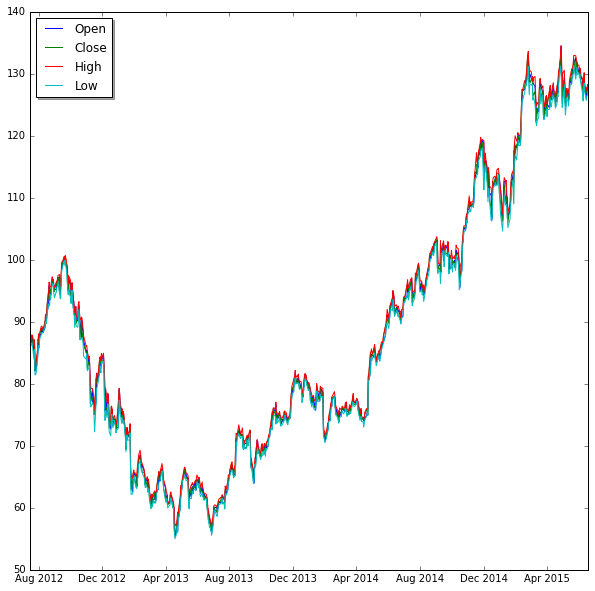

In [65]:
USO_high = USO["High"]
USO_low = USO["Low"]
USO_open = USO["Open"]
USO_close = USO["Close"]
USO_vol = USO["Volume"]

"With these fields, we will proceed to plot each of them against the date they correspond to"
fig, ax = plt.subplots()
ax.plot(USO.index, USO_open, label="Open")
ax.plot(USO.index , USO_close, label="Close")
ax.plot(USO.index, USO_high, label="High")
ax.plot(USO.index, USO_low, label="Low")
ax.legend(loc='upper left', shadow=True)

plt.show()

The basic line plot above helps us to see how the price changes overtime and the relationships among the plotted variables. However, to gain deeper insight into the data, we will need to perform more thorough analysis.


## Analysing the data

This section will seek to illustrate some of the operations we can perform on the price series. Often, manipulating the data and performing some of the techniques shown below can uncover hidden relationships that may lend insight to our research. In this case of research for the purposes of devising trading stratgies, we might uncover correlations and patterns which we can exploit to help generate profits for our trading strategy. 

Given the basic plots above, we can perhaps learn more about the characteristics of the price series by calculating some of the common metrics associated with quantifying datasets. These can include finding the various means and moments of the data as well as plotting combinations of the variables against one another.

In the code below, we will calculate the mean of the stock price, the mean of the stock's daily trading volume, its average daily range and the standard deviation. Specifics for each calculation is elaborated in the comments below.

In [66]:
"""We will take the mean of the price series of the average of all the days mid price which is defined as the 
(Day's Open + Day's Close)/2 """
USO_mean = ((USO_close + USO_open)/2).mean()

"Calculates the standar deviation of the daily mean calculated above"
USO_std = np.std(((USO_close + USO_open)/2))

"This is a measure of the average spread between the Day's high and the Day's low"
USO_range = (USO_high - USO_low)

"The average trading volume of the stock"
USO_aveVol = USO_vol.mean()

print "Mean: %f "%(USO_mean)
print "Std: %f"%(USO_std)
print "Average Daily Range: %f"%(USO_range.mean())
print "Average Daily Vloume: %d"%(USO_aveVol)

Mean: 88.110305 
Std: 21.219507
Average Daily Range: 1.626314
Average Daily Vloume: 84976708


Running the code above produces the results shown in the above. With that, we can see that daily price changes, as estimated ny the range value, is relatively small at $1.62. However the volatility of the stock price, as estimated by the Std value, over the testing period is much higher at $21.22,. This also reflects the pattern seen in the chart plotted in the previous section. 

Having these quantities gives us a rough mental picture of how our data behaves. We will now perform slightly more rigorous analysis to try to uncover other characteristics of the data set. For example we will try estimating correlations among the different fields and also try predicting price movements using various methods. 


In [67]:
import scipy

"This function calculates the pearson Correlation of two Data series"
def pearsonCorr(x, y):
    x = x - x.mean() 
    y = y - y.mean()
    return ((x * y).sum())/ np.sqrt(np.square(x).sum() * np.square(y).sum())

"We will begin with a quick calculation of the correlation between daily abnormal Volumes and daily range "
"abnormal volume is the absolute deviation from the mean"
abVol = np.abs(USO_vol - USO_aveVol) / (USO_aveVol) #normalize
#print abVol
r = pearsonCorr(USO_range, abVol)
print "Correlation USO_range vs abVol: ", r

Correlation USO_range vs abVol:  0.305981237401


This gives us a rather low correlation coefficient of 0.30598 as shown above which does not seem to be very helpful. We will thus perform more manipulations on the data to perhaps discover more helpful relationships to help us devise a strategy to trade the stock. In the following code snippet, we will attempt to find more statistically significant correlations between datasets by performing various operations on the data. Elaboration of each modification is provided as comments in the code cell below 

We will also make a new table column which we will label "returns". This column will contain the value of the day's 
(Close - Open)/ Open . Intuitively, this represents the return of our investment if we decide to buy the stock at the start of the trading day and sell it at the end of the day. We will use the returns as a way to help measure the performance/effectiveness of our strategy. Generally, the igher the return value, the better the performance.  

In [68]:
#Calculates the returns of each day as per the description above
returns = ((USO_close - USO_open)/USO_open) * 100 #express in percentage terms  
USO = USO.assign(returns=returns)

#Prev day's close - Prev day's Open, NaN columns will be filled with 0s
"""The hypothesis here is that the price changes of the stock on the day before could 
indicate the direction of the change on the current day"""
prev_ret = USO_close - USO_open 
prev_ret = prev_ret.shift(1).fillna(0.0) # shift down by 1 to align with next days returns 
corr_prev_ret = pearsonCorr(prev_ret, returns)
print "Correlation prev_ret = %06f"%(corr_prev_ret)
#prev

#Curr open - prev close, fill NaN with open price
"""The hypothesis here is that the price changes of the stock from the time of the market's
close the prior day to the time it opens on the current day might indicate overnight developments
that could predict today's returns"""
pClose = USO_close.shift(1).fillna(USO_open)
co_pc = USO_open - pClose
corr_co_pc = pearsonCorr(co_pc, returns)
print "Correlation co_pc = %06f"%(corr_co_pc)

#ratio of close price within daily range. 
#Measures the distance of close from the high and low price. Calculated using (Close- Low)/(High - Low)
"""The reasoning is that a stock that settled near its high point yesterday would be more likely to continue
that move today."""
rat_cl = (USO_close - USO_low )/ (USO_range)
rat_cl = rat_cl.shift(1).fillna(0.5) #fill nan with 0.5, assumes close is in the middle
corr_rat_cl = pearsonCorr(rat_cl, returns)
print "Correlation corr_rat_cl = %06f"%(corr_rat_cl)

# n period sliding average calculator. Finds the average of the series with an n period lookback window
def slidingAve(data, n ,start_val):
    #compute the sliding average with window size n and Series data
    length = data.shape[0]
    res = np.array([0.0] * length)
    for i in xrange(length):
        if (i < n):
            ave = np.sum(data[0:i]) + ((n-i) * start_val) #sum of rows 0 to i 
            res[i] = (ave / n)
        else:
            ave = np.sum(data[(i-n):i]) / n
            res[i] = ave
            
    return res #returns an ndarray shape(length,) 


#deviation from sliding average calculated using the previous days_close
"""This is a common indicator used by traders. It measures the difference between the current price
and the n period sliding average."""
n = 7 #arbitrary look back period length
sld_ave = slidingAve(USO_close, n, USO_close[0]) 
dev_ave = USO_open - sld_ave
corr_dev_ave = pearsonCorr(dev_ave, returns)
print "corr_dev_ave = %06f"%(corr_dev_ave)

#we will now try to pick an n that produces the highest correlation
corr = 0 
chosen_n = 0
for i in xrange(1,n + 1):
    sa = slidingAve(USO_close, i, USO_close[0])
    sa = USO_open - sa
    c = pearsonCorr(sa, returns)
    if(abs(c) > corr ):
        corr = c
        chosen_n = i 
print "chosen_n = %d , corr_dev_ave = %06f"%(chosen_n, corr)
n = chosen_n 
sld_ave = slidingAve(USO_close, n, USO_close[0]) 
dev_ave = USO_open - sld_ave


# k previous period returns to predict next days returns
"""This indicator measures the sum of the sign of the returns over the past k days. The reasoning is that
perhaps a stock that has shown positive returns over the last k days is likely or less likely to keep 
moving in the same direction. Therefore, we will use the correlation to help answer that"""
k = 2
ret_sign = np.sign(returns)
ret_sign = pd.rolling_sum(ret_sign, k , min_periods=k).shift(1).fillna(0) 
#align with correct index and fill all NaN with 0s
corr_ret_sign =  pearsonCorr(ret_sign, (returns))
print "k = %d , corr_ret_sign = %06f"%(k, corr_ret_sign)



Correlation prev_ret = -0.065980
Correlation co_pc = -0.026757
Correlation corr_rat_cl = 0.032950
corr_dev_ave = -0.025880
chosen_n = 7 , corr_dev_ave = -0.025880
k = 2 , corr_ret_sign = -0.028141


The statements above show the correlation of each of the indicators with the corresponding returns. In most of the indicators, we have to perform a shift of the series to ensure that it lags the returns of a particular day by 1. We have the option to shift more if desired but a lag of 1 time period will suffice for this tutorial. The lag is required to account for the fact that we only have access to data before the current time period. Thus if we were to use one of these indicators in our strategy to predict future returns, we can only use data that lags the current time period by at least 1 time unit. 

Also we see that most of the correlations appear to be rather low as such, bsing a strategy purely from those indicators may not perform poorly. Thus we may need to perform further analysis or look for other factors to try and derive stronger predictors/indicators. 


With that, we will now do a quick visualization of the data to get a better sense of how our indicators look in relation to the returns they correspond to. This could perhaps help us identify the cause for the low correlation, for example, a non-linear relationship instead of a linear one. 

To do that, we will plot scatter plots of each of the series (x-axis), against returns(y-axis). 


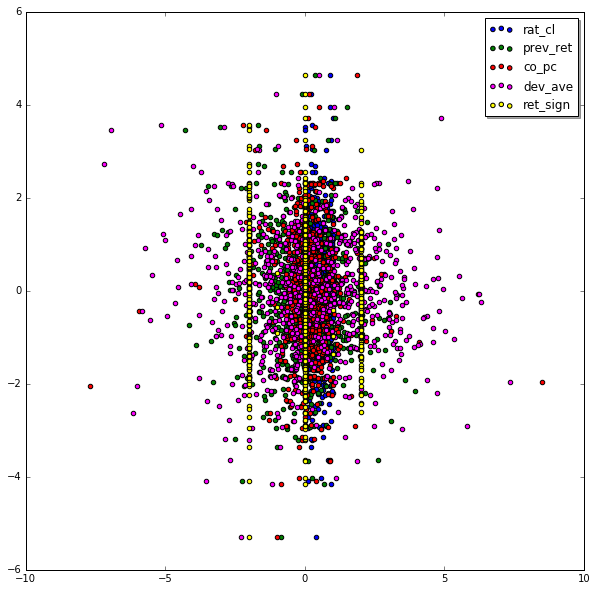

In [69]:
fig, ax = plt.subplots()
ax.scatter(rat_cl, returns, c="blue" ,label="rat_cl")
ax.scatter(prev_ret,returns, c="green",label="prev_ret")
ax.scatter(co_pc,returns, c="red",label="co_pc")
ax.scatter(dev_ave,returns, c="magenta",label="dev_ave")
ax.scatter(ret_sign,returns, c="yellow",label="ret_sign")
ax.legend(loc='upper right', shadow=True)

Based on the scatter plot, it is apparent that the data distribution seems rather random, which explains the low correlation. 

## Combining Indicators / Implementing a strategy

In this section, we will focus on methods to help consolidate our research/modifications done in the previous section into an implementable and deployable strategy for live trading. After which, we will run a out-of-sample test using our strategy to evaluate its performance.

To consolidate our data into an executable strategy, we will be using a Linear Support Vector Machine (SVM). Using the sklearn Linear SVM implementation, we will train the SVM with our dataset. The output from the Linear SVM will be a vector of coefficients which we will then use in our trading strategy. In essence the coefficient vector churned out by the SVM is a series of values that minimizes the error rate of prediction based on the training data set. More details on the process is explained below. 

In [70]:
"Helper fuction that prints out all rows of a dataframe"
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')


"""In this code section, we will be making 2 dataframes whic we will use for training. One will contain
the columns Open, High Low and Close and the other will contain our predictors/indicators in section 2. 
We will also have to create the a results table which will contain the returns of each day. This is required for 
training the SVM"""

"Operations to introduce lag to the data on the basic dataframe"
abVol = (USO_vol - USO_aveVol) / (USO_aveVol) #normalize
old_X = USO
old_X.High = old_X.High.shift(1).fillna(USO_high[0]) 
old_X.Low = old_X.Low.shift(1).fillna(USO_low[0])
old_X.Close = old_X.Close.shift(1).fillna(USO_close[0])

"""Here we create the first dataframe containing only Open High Low and Close. Care must be taken to remove any 
rows containing bogus data. We also create the corresponding results table """
unmod_X = old_X.dropna()
unmod_y = np.sign(unmod_X["returns"])
unmod_y[unmod_y==0.0] = -1.0 
unmod_X = unmod_X.drop([ "returns", "Volume"], axis=1)
#print_full(unmod_X)
print "unmod_X's features: \n", unmod_X.columns, "\n"

"""Here we create the second table containing our predictors as well as the corresponding results table."""
new_X = old_X 
new_X = new_X.assign(rat_cl=rat_cl, prev_ret=prev_ret, co_pc=co_pc, dev_ave=dev_ave, ret_sign=ret_sign)
new_X = new_X.dropna()
new_y = np.sign(new_X["returns"])
new_y[new_y == 0.0] = -1.0
new_X = new_X.drop(["returns", "Volume"], axis=1) 
print "new_X's features: \n", new_X.columns, "\n"

"In this block, we train 2 SVMs. One using the first table and the other using the second table. "
SVM_unmod = skl.LinearSVC()
SVM_unmod.fit(unmod_X, unmod_y)
SVM_new = skl.LinearSVC()
SVM_new.fit(new_X, new_y)


print "SVM_new's coefficients vector: "  
print SVM_new.coef_
print "\n", "SVM_unmod's coefficients vector: " 
print SVM_unmod.coef_ 
print "\n"
print "List of SVM prediction classes: ", new_y.unique()

unmod_X's features: 
Index([u'Open', u'High', u'Low', u'Close'], dtype='object') 

new_X's features: 
Index([    u'Open',     u'High',      u'Low',    u'Close',    u'co_pc',
        u'dev_ave', u'prev_ret',   u'rat_cl', u'ret_sign'],
      dtype='object') 

SVM_new's coefficients vector: 
[[-0.00337697 -0.01404629 -0.02829204  0.0362102  -0.03133989  0.00364895
  -0.17008714  0.39132387 -0.01159449]]

SVM_unmod's coefficients vector: 
[[-0.03200922  0.05728587  0.01673016 -0.02956674]]


List of SVM prediction classes:  [ 1. -1.]


The print statements above help us to see the coefficients produced by each of the SVMs. It also shows us the categories/columns present in each of the dataframe and helps us map each value in the coefficients vector to the feature they represent. We also see that the SVM classifies data ito 2 classes, +1 and -1. +1 indicates that the present day will see positive returns while -1 indicates the opposite. 

Now we will use our trained models to help us predict future stock prices. Our algorithm uses the coefficients generated above to predict the day's returns. Mathematically, it performs a dot product between our coefficents and a vector of corresponding features and produces a number. The sign and the magnitude of the result will determine the position we want to enter our trade in. 


Our algorithm uses the zipline package to perform the test which will be run from 01/Jan/2016 to 01/Oct/2016 . This time frame is a sample drawn outside the training time period, allowing us to evaluateour model for generality as well. The code below implements the algorithm using the coefficients from SVM_unmod and generates a performance table upon completion. To run it locally, you will need to install zipline as highlighted in the introduction.   

In [71]:
import zipline
%reload_ext zipline
print "done"


done


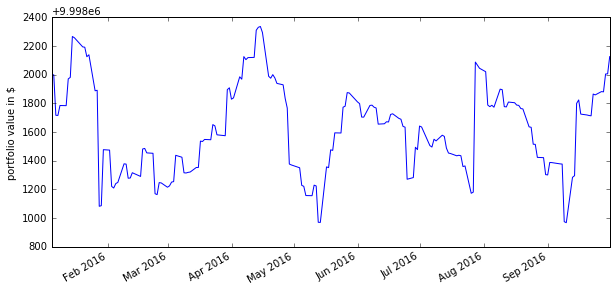

,algo_volatility,algorithm_period_return,alpha,benchmark_period_return,benchmark_volatility,beta,capital_used,ending_cash,ending_exposure,ending_value,...,short_exposure,short_value,shorts_count,sortino,starting_cash,starting_exposure,starting_value,trading_days,transactions,treasury_period_return
2016-01-04 21:00:00,NaN,0.000000e+00,NaN,-0.015304,NaN,NaN,0.0000,10000000.000000,0.000,0.000,...,0.00,0.00,0,NaN,10000000.000000,0.000,0.000,1,[],0.0224
2016-01-05 21:00:00,0.000001,-1.050000e-07,-0.000023,-0.013322,0.194371,-0.000006,-14380.4500,9985619.550000,14379.400,14379.400,...,0.00,0.00,0,-11.224972,10000000.000000,0.000,0.000,2,"[{u'commission': None, u'amount': 140, u'sid':...",0.0225
2016-01-06 21:00:00,0.000258,-2.835000e-05,-0.000876,-0.026263,0.149686,0.000679,14096.9500,9999716.500000,0.000,0.000,...,0.00,0.00,0,-9.199159,9985619.550000,14379.400,14379.400,3,"[{u'commission': None, u'amount': -140, u'sid'...",0.0218
2016-01-07 21:00:00,0.000224,-2.845350e-05,-0.001644,-0.049341,0.170060,0.000047,-13311.1350,9986405.365000,13310.100,13310.100,...,0.00,0.00,0,-7.995737,9999716.500000,0.000,0.000,4,"[{u'commission': None, u'amount': 138, u'sid':...",0.0216
2016-01-08 21:00:00,0.000218,-2.151900e-05,-0.000772,-0.059645,0.147763,0.000102,13379.4450,9999784.810000,0.000,0.000,...,0.00,0.00,0,-5.408614,9986405.365000,13310.100,13310.100,5,"[{u'commission': None, u'amount': -138, u'sid'...",0.0213
2016-01-11 21:00:00,0.000197,-2.161900e-05,-0.000490,-0.058842,0.156881,0.000166,-13006.9600,9986777.850000,13005.960,13005.960,...,0.00,0.00,0,-4.960280,9999784.810000,0.000,0.000,6,"[{u'commission': None, u'amount': 132, u'sid':...",0.0217
2016-01-12 21:00:00,0.000224,-2.943000e-06,0.000937,-0.051499,0.178716,0.000554,13692.5200,10000470.370000,-499.800,-499.800,...,-499.80,-499.80,1,-0.625034,9986777.850000,13005.960,13005.960,7,"[{u'commission': None, u'amount': -5, u'sid': ...",0.0212
2016-01-13 21:00:00,0.000207,-1.859250e-06,0.000884,-0.075178,0.192402,0.000387,-13636.6125,9986833.757500,13147.650,13147.650,...,0.00,0.00,0,-0.369321,10000470.370000,-499.800,-499.800,8,"[{u'commission': None, u'amount': 135, u'sid':...",0.0208
2016-01-14 21:00:00,0.000247,2.669450e-05,0.001853,-0.059738,0.227676,0.000652,13134.6275,9999968.385000,298.560,298.560,...,0.00,0.00,0,5.001049,9986833.757500,13147.650,13147.650,9,"[{u'commission': None, u'amount': 3, u'sid': E...",0.0210
2016-01-15 21:00:00,0.000233,2.577750e-05,0.001912,-0.080046,0.227264,0.000610,-12434.6400,9987533.745000,12724.030,12724.030,...,0.00,0.00,0,4.579029,9999968.385000,298.560,298.560,10,"[{u'commission': None, u'amount': 131, u'sid':...",0.0203


In [72]:
%%zipline --start 2016-1-1 --end 2016-10-1 -o bt_unmod

from zipline.api import order, symbol, record, history
import zipline.api as zap
import numpy as np
import matplotlib.pyplot as plt

#will need to create out_sample set for svm model 

def enterPos(context, data):
    
    info = data.history(context.sym , ["open","high", "low", "close"], 1,"1d" )
    var = info.iloc[0, :].reshape(1,4)
    entry = np.dot(var, context.coeff)[0,0]
    zap.order_target(context.sym, int(100 * entry))
    return 
        
    
def exitPos(context, data):
    zap.order_target(context.sym, 0)
    

def initialize(context):
    context.coeff = np.array([-0.02396685,  0.05665731 , 0.01046352 ,-0.03026192]).reshape(4,1)
    context.sym = symbol("aapl") 
    
    zap.schedule_function(func=enterPos, date_rule=zap.date_rules.every_day(), 
                          time_rule=zap.time_rules.market_open(minutes=1) )
    
    zap.schedule_function(func=exitPos, date_rule=zap.date_rules.every_day(), 
                          time_rule=zap.time_rules.market_close(minutes=30) )
        
    

def analyze(context, perf):
    fig = plt.figure()
    ax1 = fig.add_subplot(211)
    perf.portfolio_value.plot(ax=ax1)
    ax1.set_ylabel('portfolio value in $')
    plt.show() 
         


The table above shows the performance of our algorithm. Overall we made a small profit but suffered significant losses 
along the way. Thus as strategies go, it is not a viable one. 

Below, is a template for you to implement a strategy using the coefficients from SVM_new if you so choose. You may refer to http://www.zipline.io/appendix.html#trading-controls for help on zipline's api. Uncomment the first line of the code block below to run the backtest.  

In [74]:
#%%zipline --start 2016-1-1 --end 2016-10-1 -o bt_new

from zipline.api import order, symbol, record, history
import zipline.api as zap
import numpy as np
import matplotlib.pyplot as plt

#will need to create out_sample set for svm model 

def enterPos(context, data):
    pass
        
    
def exitPos(context, data):
    pass
    

def initialize(context):
    context.coeff = None
    context.sym = symbol("aapl") 
    
    zap.schedule_function(func=enterPos, date_rule=zap.date_rules.every_day(), 
                          time_rule=zap.time_rules.market_open(minutes=1) )
    
    zap.schedule_function(func=exitPos, date_rule=zap.date_rules.every_day(), 
                          time_rule=zap.time_rules.market_close(minutes=30) )
        
    

def analyze(context, perf):
    fig = plt.figure()
    ax1 = fig.add_subplot(211)
    perf.portfolio_value.plot(ax=ax1)
    ax1.set_ylabel('portfolio value in $')
    plt.show() 
    

## Conclusion

In summary, this tutorial showed a glimpse of the process one may undertake when devising a trading strategy. The process entailed curating data, analysing the data's characteristics and packaging the findings into an executable strategy. In reality, we would want to perform even more tests on even larger data sets to ensure statistical significance in our results. Furthermore, there are endless alternative strategies we could have consider, ranging from using multi stock correlations to deep belief networks and predictions based on social media/new feeds. 


Thank you for taking the time to peruse the notebook. I hope that it has been informative with respect to providing you with an intoductory insight into the field of algorithmic and/or quantitative trading. 
